In [3]:
pip install dash

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.5 MB/s eta 0:00:00
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3568 sha256=ad79678b9c583183ad4935ec6cc0c3732704646df5fdeb7435bc8008d663f792
  Stored in directory: /root/.cache/pip/wheels/b4/33/6d/d0820be98063da218c3206fbad2381cd2db3fbb1a0f0d254b5
Successfully built stringcase
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [4]:
pip install -U concave_hull

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 2.4 MB/s eta 0:00:00


In [6]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, generate_binary_structure
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import plotly.colors as pc
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull  # pip install -U concave_hull

from concave_hull import (  # noqa: F401
    concave_hull,
    concave_hull_indexes,
    convex_hull_indexes,
)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# Load the NIfTI file
nii_file = nib.load(r"/content/drive/My Drive/corrected_masks_ishar/corrected_mask_C0002.nii")
seg_data = nii_file.get_fdata()

how_many_planes = 10 # choose how many planes to calculate the overlap for

def construct_matrix(file_path):
    # Load the NIfTI file
    img = nib.load(file_path)
    data = img.get_fdata()  # Convert to NumPy array

    # Print shape info
    print(f"Matrix shape: {data.shape}")

    # Create and return a copy of the data (ensuring it's a NumPy array)
    return np.array(data, dtype=np.uint8)  # Convert to uint8 if intensities are discrete (0,1,2)

In [53]:
matrix_corr_mask = seg_data
print(f"Unique values in the corrected mask matrix: ",np.unique(matrix_corr_mask))

# Keep only the '2' values
matrix_aneurysm = np.zeros_like(matrix_corr_mask)
matrix_aneurysm[matrix_corr_mask == 2] = 2
print(f"Unique values in the aneurysm matrix: ",np.unique(matrix_aneurysm))

matrix_vessels = np.zeros_like(matrix_corr_mask)
matrix_vessels[matrix_corr_mask == 1] = 1
print(f"Unique values in the surface boundary green matrix: ",np.unique(matrix_vessels))

# Define 26-connectivity structure in 3D (one pixel away in any direction)
structure = generate_binary_structure(3, 3)  # 3D, full 26-neighborhood

# Find coordinates for aneurysm points (value = 2)
x, y, z = np.where(matrix_corr_mask == 2)

# Find coordinates for correlation mask points (value = 1)
x1, y1, z1 = np.where(matrix_corr_mask == 1)

# Create a mask of neighboring points that touch value = 1
dilated_mask = binary_dilation(matrix_corr_mask == 1, structure=structure)
print("Unique values in dilated_mask:", np.unique(dilated_mask))

# Find aneurysm points (value = 2) that have at least one 1-neighbor
green_mask = (matrix_corr_mask == 2) & dilated_mask
x_green, y_green, z_green = np.where(green_mask)

#Create matrix with surface points on the aneurysm-vessel boundary
surface_matrix = np.zeros_like(matrix_aneurysm)
surface_matrix = green_mask

# Get surface points
surface_points = np.argwhere(surface_matrix == 1)
print(surface_points)

# Compute PCA
pca = PCA(n_components=3)
pca.fit(surface_points)

# The normal is the eigenvector corresponding to the smallest eigenvalue
normal_vector = pca.components_[-1]  # Smallest component gives normal

# Ensure it's a unit vector
normal_vector /= np.linalg.norm(normal_vector)
print('Normal vector Ina: ',normal_vector)

# Choose a point to originate the normal (e.g., mean of surface)
origin = np.mean(surface_points, axis=0)
print('Origin Ina: ',origin)

# Step 1: Compute local coordinate system
normal_vector /= np.linalg.norm(normal_vector)  # Normalize normal  #TODO: no need again?

# Pick a reference vector for basis computation   #TODO: no need?
if abs(normal_vector[0]) < 0.9:
    reference_vector = np.array([1, 0, 0])
else:
    reference_vector = np.array([0, 1, 0])

# Compute basis vectors
basis_vector_1 = np.cross(normal_vector, reference_vector)
basis_vector_1 /= np.linalg.norm(basis_vector_1)

basis_vector_2 = np.cross(normal_vector, basis_vector_1)
basis_vector_2 /= np.linalg.norm(basis_vector_2)

# Construct the transformation matrix (Global -> Local)
T = np.column_stack([basis_vector_1, basis_vector_2, normal_vector]).T  # Transpose to map to local
print(T)
print()

# Step 2: Transform all surface points into the local coordinate system
origin = np.mean(surface_points, axis=0)
centered_points = surface_points - origin
local_points = (T @ centered_points.T).T  # Transform each point to local [x', y', n']
print(local_points)

# Extract x' and y' coordinates for the scatter plot
x_prime = local_points[:, 0]  # x' coordinates
y_prime = local_points[:, 1]  # y' coordinates

projected_2d = local_points[:, :2]  # Extract x and y coordinates

# Your 2D points (make sure 'projected_2d' is already defined) #TODO: fix comment
points = np.array(projected_2d)

# Add the first point to the end of the array to close the loop
points = np.vstack([points, points[0]])

# Compute Convex Hull using scipy
convex_hull = ConvexHull(points[:, :2])  # points are already 2D (N-by-2)

# Compute the Concave Hull and plot it
idxes = concave_hull_indexes(
    points[:, :2],
    length_threshold=0,
    # convex_hull_indexes=convex_hull.vertices.astype(np.int32),
)
print(idxes)

# Fill the area inside the Concave Hull with black color
concave_x = points[idxes, 0]  # X coordinates of the concave hull points
concave_y = points[idxes, 1]  # Y coordinates of the concave hull points

# Get the concave hull points
concave_hull_points = points[idxes]
print(concave_hull_points)

# Function to project points onto a 1D line at a given angle
def project_onto_line(points, angle):
    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Define the unit vector for the projection direction
    direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])

    # Project each point of the concave hull onto the direction (dot product)
    projection = np.dot(points, direction)

    return projection

# Define angles to project the concave hull onto (0 to 180 degrees)
angles = np.linspace(0, 360, 361)  # From 0 to 180 degrees
print(angles)
projections = []
projection_ranges = []

# Plot projections for each angle and find the angle with the shortest projection range
for angle in angles:
    # Project the concave hull onto the 1D line at each angle
    projection = project_onto_line(concave_hull_points, angle)

    # Calculate the range of the projection (max - min)
    projection_range = np.max(projection) - np.min(projection)
    projection_ranges.append(projection_range)

# print(projection_ranges)
angles_ranges = [(angles[i], projection_ranges[i]) for i in range (0, 360)]
angles_ranges_sorted = sorted(angles_ranges, key=lambda x: x[1])
print('-----')
print(angles_ranges_sorted)

# Find the angle with the shortest 1D projection
shortest_projection_angle = angles[np.argmin(projection_ranges)]
print(shortest_projection_angle)

# Find the angle with the longest 1D projection
longest_projection_angle = angles[np.argmax(projection_ranges)]
print(longest_projection_angle)

# Step 1: Calculate the unit vector in the 2D plane corresponding to the projection angle
shortest_projection_angle_rad = np.deg2rad(angles_ranges_sorted[0][0])  # Convert theta to radians
u_2d_local = np.array([np.cos(shortest_projection_angle_rad), np.sin(shortest_projection_angle_rad)])

# Transformation matrix (local to global)
T_inv = np.linalg.inv(T)

# Step 2: Transform the 2D local vector back to the global coordinate system
u_2d_global = T_inv @ np.append(u_2d_local, 0)  # Append 0 for the normal component (since u_2d_local is 2D)

# make a list with 3D projection vectors sorted from most optimal projection vector to least optimal

shortest_projection_angle_rad_list = np.deg2rad(angles_ranges_sorted)

u_2d_local_list = []
for angle in shortest_projection_angle_rad_list:
    u_2d_local_list.append(np.array([np.cos(angle[0]), np.sin(angle[0])]))
print(u_2d_local_list)

u_2d_global_list = []
for u_2d_local in u_2d_local_list:
    u_2d_global_list.append(T_inv @ np.append(u_2d_local, 0))
print(u_2d_global_list)

# Compute the list with global projection directions
projection_direction_list = []
for u_2d_global in u_2d_global_list:
    projection_direction_list.append(np.cross(normal_vector, u_2d_global))
    projection_direction_list[-1] /= np.linalg.norm(projection_direction_list[-1])  # Normalize

print(projection_direction_list)


Unique values in the corrected mask matrix:  [0. 1. 2.]
Unique values in the aneurysm matrix:  [0. 2.]
Unique values in the surface boundary green matrix:  [0. 1.]
Unique values in dilated_mask: [False  True]
[[140  94 107]
 [140  94 108]
 [140  95 108]
 ...
 [152  91 119]
 [152  92 119]
 [152  93 119]]
Normal vector Ina:  [ 0.65166059  0.6772698  -0.34153198]
Origin Ina:  [146.46527778  92.4212963  112.7662037 ]
[[ 0.         -0.45026653 -0.8928942 ]
 [-0.7585107   0.58186396 -0.29342095]
 [ 0.65166059  0.6772698  -0.34153198]]

[[ 4.43777242  7.51449811 -1.1746154 ]
 [ 3.54487822  7.22107716 -1.51614738]
 [ 3.09461169  7.80294112 -0.83887758]
 ...
 [-4.92615842 -6.85427353  0.51511849]
 [-5.37642495 -6.27240957  1.19238829]
 [-5.82669147 -5.69054562  1.8696581 ]]
[379 322 324 281 241 209 170 132 103 102 101  67  66  37  13  12  11  10
   9   7   6   5   4   2 432  21  18  16  15  40  14  68 104 133 171 211
 247 242 287 282 337 404 329 394 386 425 387 423 381 382 385 391 392 393
 402 

In [54]:
# Downsampling function
def downsample_coordinates(x, y, z, factor=2):
    indices = np.arange(0, len(x), factor)
    return x[indices], y[indices], z[indices]

# Find vessel and aneurysm coordinates
x1, y1, z1 = downsample_coordinates(*np.where(seg_data == 1), factor=2)
x2, y2, z2 = downsample_coordinates(*np.where(seg_data == 2), factor=2)

print(normal_vector)
center_x,center_y,center_z = origin[0], origin[1], origin[2]
print(center_x,center_y,center_z)

# Compute two perpendicular vectors
v1, v2 = basis_vector_1, basis_vector_2
print(v1,v2)

# Find valid plane length
def find_plane_endpoints(center, direction, image_shape):
    return min(min(abs((0 - center[i]) / direction[i]), abs((image_shape[i] - center[i]) / direction[i])) if direction[i] != 0 else float('inf') for i in range(3))

# Compute maximum width
def calculate_max_width(x, y, z):
    points = np.vstack((x, y, z)).T  # Combine x, y, z coordinates into a single array of points
    distances = cdist(points, points)  # Calculate pairwise distances between all points
    np.fill_diagonal(distances, 0)  # Set the diagonal to zero because we don't want to compare a point to itself
    max_dist = np.max(distances)  # Find the maximum distance
    return max_dist

image_shape = seg_data.shape  # Image dimensions

# Generate points on the plane
def generate_plane_points(left_start, left_end, right_start, right_end, num_points=100):
    # Create a grid of points on the plane using the two directions
    vector1 = left_end - left_start
    vector2 = right_start - left_start
    points = []
    for i in np.linspace(0, 1, num_points):
        for j in np.linspace(0, 1, num_points):
            point = left_start + i * vector1 + j * vector2
            points.append(point)
    return np.array(points)


# Count red pixels (vessel or aneurysm points)
def count_red_pixels_on_plane(points, seg_data):
    count = 0
    for point in points:
        # Round the point to nearest voxel indices (ensure they are within bounds)
        x, y, z = np.round(point).astype(int)
        if 0 <= x < seg_data.shape[0] and 0 <= y < seg_data.shape[1] and 0 <= z < seg_data.shape[2]:
            if seg_data[x, y, z] == 1:  # Assuming '1' corresponds to the red pixels (vessel)
                count += 1
    return count

[ 0.65166059  0.6772698  -0.34153198]
146.46527777777777 92.42129629629629 112.76620370370371
[ 0.         -0.45026653 -0.8928942 ] [-0.7585107   0.58186396 -0.29342095]


In [36]:
!pip install dash jupyter-dash --upgrade
from dash import dcc, html

In [55]:
# Dash app
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H3("3D Visualization of Cerebral Vessels, Aneurysms, and Viewing Planes"),
    dcc.Graph(id='3d-plot', config={'scrollZoom': True}, style={'height': '80vh'}),
    html.Label("Number of Planes:"),
    dcc.Slider(id='num-planes-slider', min=1, max=360, step=1, value=how_many_planes,
               marks={i: str(i) for i in range(4, 37, 4)}, tooltip={"placement": "bottom", "always_visible": True})
])

# Generate a list of distinct colors from Plotly's predefined color scale
color_list = pc.qualitative.Set1  # or you can choose other color scales like Set2, Set3, etc.

@app.callback(Output('3d-plot', 'figure'), Input('num-planes-slider', 'value'))
def update_3d_plot(_):
    fig = go.Figure()

    # Add vessels, aneurysms, and connection region
    fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1, mode='markers', marker=dict(size=2, color='red'), name="Vessels"))
    fig.add_trace(go.Scatter3d(x=x2, y=y2, z=z2, mode='markers', marker=dict(size=2, color='blue'), name="Aneurysms"))
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color='green'), name="Connection"))

    # Generate a list of distinct colors from Plotly's predefined color scale
    color_list = pc.qualitative.Set1  # Choose color set

    for i, (angle, max_width) in enumerate(angles_ranges_sorted[0:how_many_planes]):
        plane_color = color_list[i % len(color_list)]  # Ensure we loop through the color list

        angle = angle #+ 90

        angle_rad = np.deg2rad(angle)
        rotated_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
        # direction_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
        max_length = find_plane_endpoints([center_x, center_y, center_z], rotated_vector, image_shape)
        half_width = max_width / 2

        start = np.array([center_x, center_y, center_z])
        # left_start = start - half_width * v1 - half_width * v2
        # right_start = start + half_width * v1 + half_width * v2
        # left_end = left_start + direction_vector * max_length
        # right_end = right_start + direction_vector * max_length

        left_start = start + np.cos(angle_rad) * v1 * -half_width + np.sin(angle_rad) * v2 * -half_width
        right_start = start + np.cos(angle_rad) * v1 * half_width + np.sin(angle_rad) * v2 * half_width

        # Compute the direction vectors from 'start' to each point
        left_vector = left_start - start
        right_vector = right_start - start

        # Normalize the vectors to ensure correct scaling
        left_vector /= np.linalg.norm(left_vector)
        right_vector /= np.linalg.norm(right_vector)

        # Adjust left and right start to be exactly max_width apart
        left_start = start + left_vector * (-max_width / 2)
        right_start = start + right_vector * (max_width / 2)

        # Compute the perpendicular direction (cross product with normal_vector)
        perpendicular_direction = np.cross(normal_vector, left_vector)
        perpendicular_direction /= np.linalg.norm(perpendicular_direction)  # Normalize

        # Move the start points along the perpendicular direction
        left_start += perpendicular_direction * half_width
        right_start -= perpendicular_direction * half_width

        left_end = left_start + rotated_vector * max_length
        right_end = right_start + rotated_vector * max_length

        fig.add_trace(go.Mesh3d(
            x=[left_start[0], left_end[0], right_end[0], right_start[0]],
            y=[left_start[1], left_end[1], right_end[1], right_start[1]],
            z=[left_start[2], left_end[2], right_end[2], right_start[2]],
            i=[0, 1, 2, 0], j=[1, 2, 3, 2], k=[2, 3, 0, 3],
            opacity=0.5, color=plane_color, name=f"Plane {angle:.1f}°"
        ))

        # Count red pixels on the plane
        red_pixel_count = count_red_pixels_on_plane(generate_plane_points(left_start, left_end, right_start, right_end, num_points=100), seg_data)
        print(f"Color: {plane_color}, Angle: {angle:.1f}°, Width: {max_width}, Red pixel count on plane: {red_pixel_count}")

    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"), margin=dict(l=0, r=0, b=0, t=0))
    return fig


# Run the app in inline mode for Colab
if __name__ == '__main__':
    app.run(debug = True, port = 8053)  # Use app.run() instead of app.run_server()

<IPython.core.display.Javascript object>

In [56]:
import numpy as np

# Assuming u_2d_global is a 3D vector, e.g., [x, y, z]
print("u_2d_global:", u_2d_global)

# Use only the x and y components of the 3D vector to calculate the polar angle
x_polar = u_2d_global[0]  # x component of the 3D vector
y_polar = u_2d_global[1]  # y component of the 3D vector

# Calculate the polar angle (in radians) using atan2
polar_angle = np.arctan2(y_polar, x_polar)

# Optionally, convert to degrees
polar_angle_degrees = np.degrees(polar_angle)

print(f"Polar angle (radians): {polar_angle}")
print(f"Polar angle (degrees): {polar_angle_degrees}")

u_2d_global: [0.11865722 0.35369942 0.92780234]
Polar angle (radians): 1.2471197613939713
Polar angle (degrees): 71.45469887523682


In [57]:
#make dictionary with angle and red pixel count
dict_angle = {}

for i, (angle, max_width) in enumerate(angles_ranges_sorted[0:how_many_planes]):

    print(angle, max_width)
    angle = angle #+ 90

    angle_rad = np.deg2rad(angle)
    rotated_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
    # direction_vector = np.cos(angle_rad) * v1 + np.sin(angle_rad) * v2
    max_length = find_plane_endpoints([center_x, center_y, center_z], rotated_vector, image_shape)
    half_width = max_width / 2

    start = np.array([center_x, center_y, center_z])
    # left_start = start - half_width * v1 - half_width * v2
    # right_start = start + half_width * v1 + half_width * v2
    # left_end = left_start + direction_vector * max_length
    # right_end = right_start + direction_vector * max_length

    left_start = start + np.cos(angle_rad) * v1 * -half_width + np.sin(angle_rad) * v2 * -half_width
    right_start = start + np.cos(angle_rad) * v1 * half_width + np.sin(angle_rad) * v2 * half_width

    # Compute the direction vectors from 'start' to each point
    left_vector = left_start - start
    right_vector = right_start - start

    # Normalize the vectors to ensure correct scaling
    left_vector /= np.linalg.norm(left_vector)
    right_vector /= np.linalg.norm(right_vector)

    # Adjust left and right start to be exactly max_width apart
    left_start = start + left_vector * (-max_width / 2)
    right_start = start + right_vector * (max_width / 2)

    # Compute the perpendicular direction (cross product with normal_vector)
    perpendicular_direction = np.cross(normal_vector, left_vector)
    perpendicular_direction /= np.linalg.norm(perpendicular_direction)  # Normalize

    # Move the start points along the perpendicular direction
    left_start += perpendicular_direction * half_width
    right_start -= perpendicular_direction * half_width

    left_end = left_start + rotated_vector * max_length
    right_end = right_start + rotated_vector * max_length

    # Count red pixels on the plane
    red_pixel_count = count_red_pixels_on_plane(generate_plane_points(left_start, left_end, right_start, right_end, num_points=100), seg_data)
    print(f"Red pixel count on plane {angle:.1f}° : {red_pixel_count}")
    #add red pixel count to dictionary
    dict_angle[angle] = red_pixel_count


92.0 16.553540504743367
Red pixel count on plane 92.0° : 301
272.0 16.55354050474337
Red pixel count on plane 272.0° : 254
93.0 16.57291642878351
Red pixel count on plane 93.0° : 326
273.0 16.57291642878351
Red pixel count on plane 273.0° : 308
94.0 16.587244081933996
Red pixel count on plane 94.0° : 349
274.0 16.587244081934003
Red pixel count on plane 274.0° : 352
98.0 16.594007789719605
Red pixel count on plane 98.0° : 413
278.0 16.594007789719605
Red pixel count on plane 278.0° : 579
91.0 16.595741736175288
Red pixel count on plane 91.0° : 273
271.0 16.59574173617529
Red pixel count on plane 271.0° : 217


In [58]:
print(dict_angle)
sorted_dict = sorted(dict_angle.items(), key=lambda x: x[1])
print(sorted_dict)

{np.float64(92.0): 301, np.float64(272.0): 254, np.float64(93.0): 326, np.float64(273.0): 308, np.float64(94.0): 349, np.float64(274.0): 352, np.float64(98.0): 413, np.float64(278.0): 579, np.float64(91.0): 273, np.float64(271.0): 217}
[(np.float64(271.0), 217), (np.float64(272.0), 254), (np.float64(91.0), 273), (np.float64(92.0), 301), (np.float64(273.0), 308), (np.float64(93.0), 326), (np.float64(94.0), 349), (np.float64(274.0), 352), (np.float64(98.0), 413), (np.float64(278.0), 579)]


# Ina's addition for getting the 2D projection based on Willem's overlap !
# Final projection images (width + overlap taken into consideration)

[array([ 0.75839517, -0.58963357,  0.27779311]), array([ 0.75804863, -0.59722358,  0.26208065]), array([-0.75839517,  0.58963357, -0.27779311]), array([-0.75804863,  0.59722358, -0.26208065]), array([ 0.75747119, -0.60463166,  0.24628835]), array([-0.75747119,  0.60463166, -0.24628835]), array([-0.756663  ,  0.61185557, -0.23042104]), array([ 0.756663  , -0.61185557,  0.23042104]), array([-0.75112892,  0.63886629, -0.16629854]), array([ 0.75112892, -0.63886629,  0.16629854])]


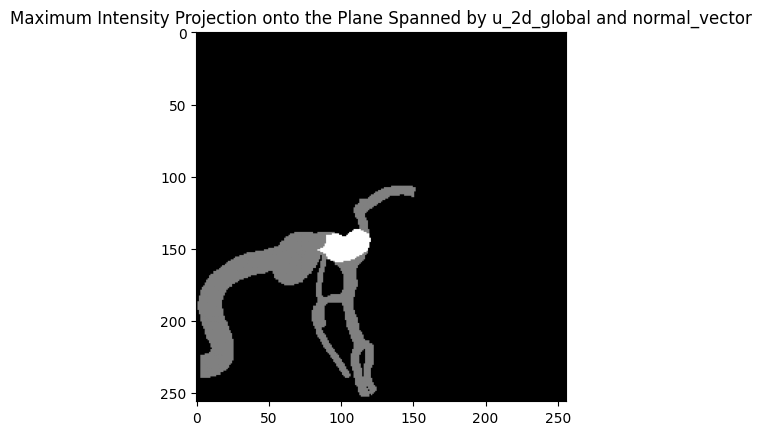

In [66]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# make a list with 3D projection vectors sorted from most optimal projection vector to least optimal
# use the dictionary obtained from Willem to get the angle with least overlap from first how_many_planes optimal projection angles (e.g. first 10 optimal projection angles)

optimal_angles_including_overlap = [angle for angle, count in sorted_dict]

# Convert to radians
final_projection_angle_rad_list = np.deg2rad(optimal_angles_including_overlap)

# Create a list of 2D unit vectors (u_2d_local)
u_2d_local_list = []
for angle in final_projection_angle_rad_list:
    u_2d_local_list.append(np.array([np.cos(angle), np.sin(angle)]))  # No need for angle[0]

u_2d_global_list = []
for u_2d_local in u_2d_local_list:
    u_2d_global_list.append(T_inv @ np.append(u_2d_local, 0))
print(u_2d_global_list)

# Compute the list with global projection directions
projection_direction_list = []
for u_2d_global in u_2d_global_list:
    projection_direction_list.append(np.cross(normal_vector, u_2d_global))
    projection_direction_list[-1] /= np.linalg.norm(projection_direction_list[-1])  # Normalize

def project_3D_to_2D_max_intensity(matrix_3D, projection_direction, method="max"):
    """
    Projects a 3D matrix onto a 2D plane by performing a maximum intensity projection
    along a given direction (projection_direction).

    Args:
        matrix_3D (np.ndarray): The 3D volume with different gray values.
        projection_direction (np.ndarray): The direction to project the data along.
        method (str): Projection method - "max" (default), "mean", or "sum".

    Returns:
        np.ndarray: 2D projected matrix.
    """
    # Normalize the projection direction (just in case)
    projection_direction = projection_direction / np.linalg.norm(projection_direction)

    # Compute the axis of projection by finding the dominant axis (x, y, or z)
    axis = np.argmax(np.abs(projection_direction))

    # Perform the maximum intensity projection along the identified axis
    if method == "max":
        projected_2D = np.max(matrix_3D, axis=axis)  # Maximum Intensity Projection
    elif method == "mean":
        projected_2D = np.mean(matrix_3D, axis=axis)  # Mean Projection
    elif method == "sum":
        projected_2D = np.sum(matrix_3D, axis=axis)  # Sum Projection
    else:
        raise ValueError("Invalid method. Choose 'max', 'mean', or 'sum'.")

    return projected_2D



# Step 2: Perform the Maximum Intensity Projection along this direction
projected_2D = project_3D_to_2D_max_intensity(matrix_corr_mask, projection_direction_list[0], method="max")

# Step 3: Plot the 2D projection
plt.imshow(projected_2D, cmap='gray')
plt.title("Maximum Intensity Projection onto the Plane Spanned by u_2d_global and normal_vector")
plt.show()

#### Obtaining the 2D optimal angle

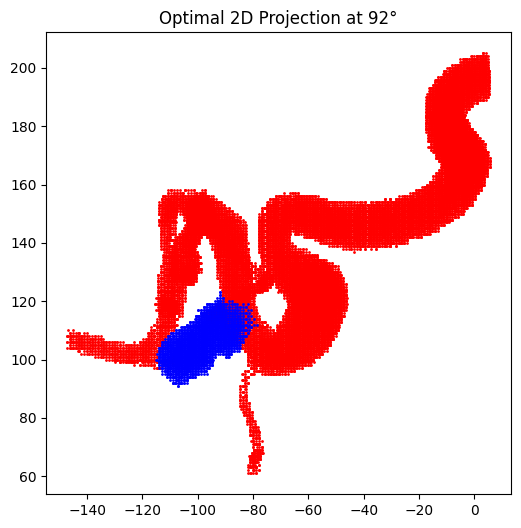

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Define the angle for the 2D projection
angle = 182-90 # Replace with your desired angle

# Convert the angle to radians
angle_rad = np.radians(angle)
1# Define the projection direction
projection_vector = np.array([np.cos(angle_rad), np.sin(angle_rad), 0])

# Project the 3D points onto the 2D plane
projected_x_vessels = x1 * projection_vector[0] + y1 * projection_vector[1]
projected_y_vessels = z1  # Keep the z-coordinate as the second axis for the 2D plot

projected_x_aneurysm = x2 * projection_vector[0] + y2 * projection_vector[1]
projected_y_aneurysm = z2

# Flip the x-axis to correct for mirroring (if needed)
projected_x_vessels = -projected_x_vessels
projected_x_aneurysm = -projected_x_aneurysm

# Generate the 2D plot
plt.figure(figsize=(6, 6))
plt.scatter(projected_x_vessels, projected_y_vessels, s=1, c='red', label='Vessels')
plt.scatter(projected_x_aneurysm, projected_y_aneurysm, s=1, c='blue', label='Aneurysm')
plt.title(f'Optimal 2D Projection at {angle}°')
plt.grid(False)

# Save the plot as a PNG file
plt.savefig(r'D:\Team_challenge\results\C002_least_overlap.png', dpi=300)

# Show the plot
plt.show()


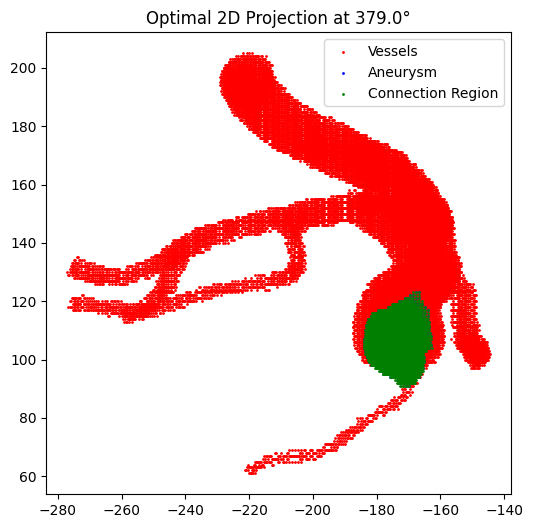

In [62]:
# Project the 3D points onto the 2D plane
projected_x_vessels = x1 * projection_vector[0] + y1 * projection_vector[1]
projected_y_vessels = z1  # Keep the z-coordinate as the second axis for the 2D plot

projected_x_aneurysm = x2 * projection_vector[0] + y2 * projection_vector[1]
projected_y_aneurysm = z2

projected_x_connection = x * projection_vector[0] + y * projection_vector[1]
projected_y_connection = z  # Keep the z-coordinate as the second axis for the 2D plot

# Ensure all projected arrays have the same length
if len(projected_x_vessels) != len(projected_y_vessels):
    raise ValueError("Mismatch in dimensions of projected_x_vessels and projected_y_vessels")

if len(projected_x_aneurysm) != len(projected_y_aneurysm):
    raise ValueError("Mismatch in dimensions of projected_x_aneurysm and projected_y_aneurysm")

if len(projected_x_connection) != len(projected_y_connection):
    raise ValueError("Mismatch in dimensions of projected_x_connection and projected_y_connection")

# Flip the x-axis to correct for mirroring (if needed)
projected_x_vessels = -projected_x_vessels
projected_x_aneurysm = -projected_x_aneurysm
projected_x_connection = -projected_x_connection

# Generate the 2D plot
plt.figure(figsize=(6, 6))
plt.scatter(projected_x_vessels, projected_y_vessels, s=1, c='red', label='Vessels')
plt.scatter(projected_x_aneurysm, projected_y_aneurysm, s=1, c='blue', label='Aneurysm')
plt.scatter(projected_x_connection, projected_y_connection, s=1, c='green', label='Connection Region')
plt.title(f'Optimal 2D Projection at {angle}°')
plt.legend()
plt.grid(False)

# Save the plot as a PNG file
plt.savefig(r'D:\Team_challenge\results\2D_projection_with_connection.png', dpi=300)

# Show the plot
plt.show()
